In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import scipy
import corner
import pymc3 as pm
import seaborn as sns
import os
import time

import theano
import theano.tensor as T
from theano.ifelse import ifelse

import sys
sys.path.append("../theano_ops")
sys.path.append("../codebase")
from data_preprocessing_ogle import process_data
from plotting_utils import plot_data
from theano_ops.celerite.factor import FactorOp
from theano_ops.celerite.solve import SolveOp
from theano_ops.celerite import terms
from theano_ops.celerite.celerite import log_likelihood

from scipy.special import gamma
from scipy.stats import invgamma
from scipy.optimize import fsolve
mpl.rc('text', usetex=False)

%matplotlib inline

In [2]:
def solve_for_invgamma_params(params, x_min, x_max):
    """Returns parameters of an inverse gamma distribution p(x) such that 
    0.1% of total prob. mass is assigned to values of x < x_min and 
    1% of total prob. masss  to values greater than x_max."""
    def inverse_gamma_cdf(x, alpha, beta):
        return invgamma.cdf(x, alpha, scale=beta)

    lower_mass = 0.001
    upper_mass = 0.99

    # Trial parameters
    alpha, beta = params

    # Equation for the roots defining params which satisfy the constraint
    return (inverse_gamma_cdf(2*x_min, alpha, beta) - \
    lower_mass, inverse_gamma_cdf(x_max, alpha, beta) - upper_mass)


def fit_pymc3_model(t, F, sigF):
    model = pm.Model()

    # SPECIFICATION OF PRIORS
    # Compute parameters for the prior on GP hyperparameters
    invgamma_a, invgamma_b =  fsolve(solve_for_invgamma_params, (0.1, 0.1), 
        (np.median(np.diff(t)), t[-1] - t[0]))

    strt = time.time()
    with model:    
                # log density of the joint prior for (tE, teff)
        def joint_density(value):
            teff = T.cast(value[0], 'float64')
            tE = T.cast(value[1], 'float64')
            sig_tE = T.cast(365., 'float64')
            sig_u0 = T.cast(1., 'float64')
            return -T.log(tE) - (teff/tE)**2/sig_u0**2 - tE**2/sig_tE**2

        # Priors for GP hyperparameters
        def ln_rho_prior(ln_rho):
            lnpdf_lninvgamma = lambda  x, a, b: np.log(x) + a*np.log(b) -\
                 (a + 1)*np.log(x) - b/x - np.log(gamma(a)) 

            res = lnpdf_lninvgamma(np.exp(ln_rho), invgamma_a, invgamma_b)
            return T.cast(res, 'float64')

        ln_rho = pm.DensityDist('ln_rho', ln_rho_prior, testval = 0.6)

        def ln_sigma_prior(ln_sigma):
            sigma = np.exp(ln_sigma)
            res = np.log(sigma) - sigma**2/3.**2
            return T.cast(res, 'float64')

        ln_sigma = pm.DensityDist('ln_sigma', ln_sigma_prior, testval=2.)

        # Priors for unknown model parameters
#         BoundedNormal = pm.Bound(pm.Normal, lower=0.0) # DeltaF is positive
#         DeltaF = BoundedNormal('DeltaF', mu=np.max(F), sd=1.)
#         Fb = pm.Normal('Fb', mu=0., sd=0.1)
#         t0 = pm.Uniform('t0', 0, 1.)
#         teff_tE = pm.DensityDist('teff_tE', joint_density, shape=2, 
#             testval = [0.1, 10.])

#         u_K = pm.Uniform('u_K', -1., 1.)

#         K = ifelse(u_K < 0., T.cast(1., 'float64'), 1. - T.log(1. - u_K))

        # Transform t0 to sensible units
#         t0 = (t[-1] - t[0])*t0 + t[0]

#         teff = teff_tE[0]
#         tE = teff_tE[1]
#         u0 = teff/tE

        # CALCULATE LIKELIHOOD
        def custom_log_likelihood(t, F, sigF):
            # Set up mean model
#             u0 = teff/tE
            
#             u = T.sqrt(u0**2 + ((t - t0)/tE)**2)

#             A = lambda u: (u**2 + 2)/(u*T.sqrt(u**2 + 4))

#             mean_function = DeltaF*(A(u) - 1)/(A(u0) - 1) + Fb

            kernel = terms.Matern32Term(sigma=T.exp(ln_sigma), rho=T.exp(ln_rho))

            loglike = log_likelihood(kernel, 0., 1.4*sigF, t, F)

            return loglike 

        logl = pm.DensityDist('logl', custom_log_likelihood,  observed={'t': t, 'F':F, 'sigF': sigF})

        # Initial parameters for the sampler
#         t0_guess_idx = (np.abs(F - np.max(F))).argmin()

#         # Initialization of the chain
#         start = {'DeltaF':np.max(F), 'Fb':0.,
#             't0':(t[t0_guess_idx] - t[0])/(t[-1] - t[0])}

        for RV in model.basic_RVs:
            print(RV.name, RV.logp(model.test_point))

        # Fit model with NUTS
        trace = pm.sample(500, tune=1000, nuts_kwargs=dict(target_accept=.95))

    return trace

Loaded events: ['blg-0001']
ln_rho -1.424163453815666
ln_sigma -4.066461114793804


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


logl -1762.0739539179888


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ln_sigma, ln_rho]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:24<00:00, 117.24draws/s]


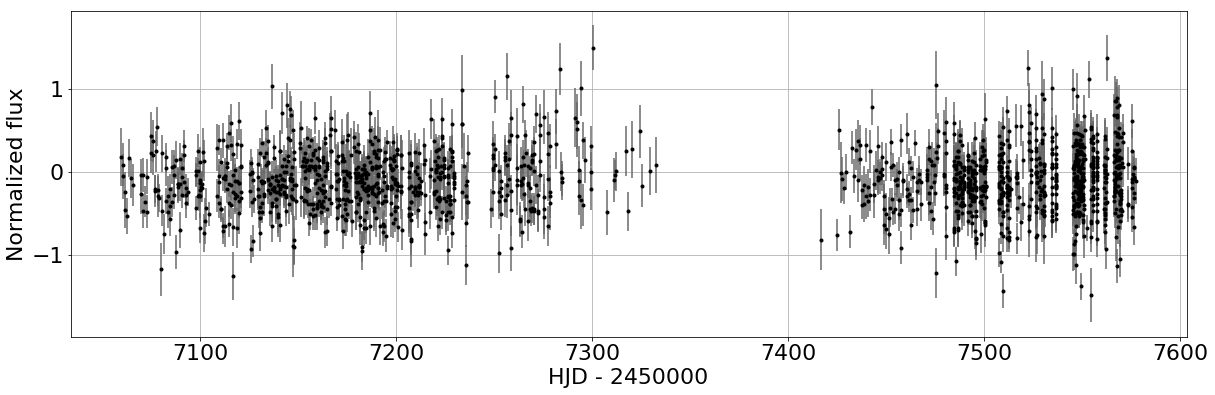

In [5]:
events = [] # event names
lightcurves = [] # data for each event
 
i = 0
n_events = 1
for entry in os.scandir('/home/star/fb90/data/OGLE_ews/2017/'):
    if entry.is_dir() and (i < n_events):
        events.append(entry.name)
        photometry = np.genfromtxt(entry.path + '/phot.dat', usecols=(0,1,2))
        lightcurves.append(photometry)
        i = i + 1
        
print("Loaded events:", events)

for event_index, lightcurve in enumerate(lightcurves):
    # Pre process the data
    t, F, sigF = process_data(lightcurve[:, 0], lightcurve[:, 1], 
        lightcurve[:, 2], standardize=True)
    
    t = t[:1700]
    F = F[:1700]
    sigF = sigF[:1700]

    fig, ax = plt.subplots(figsize=(20, 6))

    plot_data(ax, t, F, sigF)

    # Fit pymc3 model
    dense_trace = fit_pymc3_model(t, F, sigF)

In [6]:
pm.stats.summary(dense_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ln_rho,5.349815,0.953578,0.035353,3.832532,7.490934,652.277746,1.000109
ln_sigma,-2.114307,0.423063,0.015846,-2.796263,-1.157204,678.531967,1.000388


/home/star/fb90/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/star/fb90/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


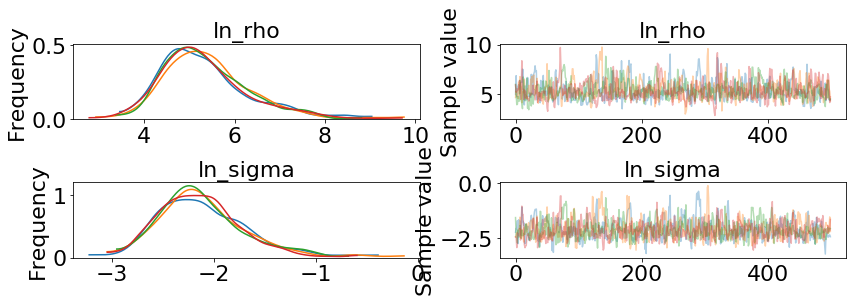

In [7]:
_ = pm.traceplot(dense_trace)